In [4]:
import pandas as pd
import numpy as np
import sqlalchemy as sqla
from io import StringIO

#establish connection to database
conn = sqla.create_engine('sqlite:///yelp.sqlite')

In [6]:
#split business.json into bussines, attributes, hours and store in a database 
business=pd.read_json("/Users/sihuili/Downloads/yelp_dataset/yelp_academic_dataset_business.json",lines=True)
business.set_index("business_id",inplace=True)

attributes=pd.DataFrame.from_dict(business["attributes"].dropna().to_dict(),orient="index")
attributes.index.name="business_id"

hours=pd.DataFrame.from_dict(business["hours"].dropna().to_dict(),orient="index")
hours.index.name="business_id"

business.drop(["hours","attributes"],axis=1,inplace=True)

business.to_sql('business',conn,if_exists="replace")
hours.to_sql('hours',conn,if_exists="replace")
attributes.to_sql('attributes',conn,if_exists="replace")

#convert checkin.json into clean and neat dataframe and store in the database
checkins=pd.read_json("/Users/sihuili/Downloads/yelp_dataset/yelp_academic_dataset_checkin.json",lines=True,orient="record",chunksize=10000)
for checkin in checkins:
    checkin.set_index("business_id",inplace=True)
    checkin=pd.DataFrame.from_dict(checkin["time"].to_dict(),orient="index")
    checkin.reset_index(inplace=True)
    checkin=checkin.melt(id_vars="index")
    days=pd.read_table(StringIO(checkin['variable'].to_csv(None,index=None)),sep='-',header=None)
    checkin=checkin.join(days)
    checkin.drop("variable",axis=1,inplace=True)
    checkin=checkin[["index",0,1,"value"]]
    checkin.columns=["business_id","weekday","hour","checkins"]
    checkin.set_index("business_id",inplace=True)
    checkin["weekday"]=checkin["weekday"].astype("category")
    checkin.dropna(inplace=True)
    checkin.to_sql('checkin',conn,if_exists="append")

#store review.json into the database
reviews=pd.read_json("/Users/sihuili/Downloads/yelp_dataset/yelp_academic_dataset_review.json",chunksize=100000,lines=True)
for review in reviews:
    review.set_index("business_id",inplace=True)
    review.to_sql("review",conn,if_exists="append")

In [7]:
import sqlite3
conn = sqlite3.connect('yelp.sqlite')
c = conn.cursor()

In [8]:
cursor = c.execute(''' Select * from checkin; ''')
business_id = []
day_of_week = []
checkin_hours = []
check_in_counts = []
for i in cursor:
    business_id.append(i[0])
    day_of_week.append(i[1])
    checkin_hours.append(i[2])
    check_in_counts.append(i[3])

In [31]:
checkin_df = pd.DataFrame({'business_id':business_id, 'day_of_week':day_of_week, 'checkin_hours':checkin_hours, 'check_in_counts':check_in_counts})

checkin_data = checkin_df.fillna("0")

checkin_df.to_csv("checkin.csv")

In [32]:
business.to_csv("business.csv")
hours.to_csv("hours.csv")
attributes.to_csv("attributes.csv")

# Find the businesses with top 10 number of checkin counts

In [21]:
unique_checkin_counts = checkin_df.groupby("business_id")["check_in_counts"].sum()

checkin_top10 = unique_checkin_counts.sort_values(ascending = False)[:10]


In [54]:
[list(business.name[business.index == i]) for i in checkin_top10.index]

[['McCarran International Airport'],
 ['Phoenix Sky Harbor International Airport'],
 ['Charlotte Douglas International Airport'],
 ['The Cosmopolitan of Las Vegas'],
 ['Kung Fu Tea'],
 ['ARIA Resort & Casino'],
 ['The Venetian Las Vegas'],
 ['Bellagio Hotel'],
 ['MGM Grand Hotel'],
 ['Caesars Palace Las Vegas Hotel & Casino']]

In [55]:
checkin_top10

business_id
FaHADZARwnY4yvlvpnsfGA    138477.0
JmI9nslLD7KZqRr__Bg6NQ    118185.0
yQab5dxZzgBLTEHCw9V7_w     52675.0
5LNZ67Yw9RD6nf4_UhXOjw     45416.0
IZivKqtHyz4-ts8KsnvMrA     36327.0
SMPbvZLSMMb7KU76YNYMGg     33733.0
Wxxvi3LZbHNIDwJ-ZimtnA     31591.0
na4Th5DrNauOv-c43QQFvA     30339.0
El4FC8jcawUVgw_0EIcbaQ     29318.0
VyjyHoBg3KC5BSFRlD0ZPQ     28427.0
Name: check_in_counts, dtype: float64

# which day of week has the highest number of checkin counts?

In [87]:
checkin_dow_total = checkin_df.groupby('day_of_week')['check_in_counts'].sum().sort_values(ascending = False)
checkin_dow_total

day_of_week
Sat    3545990.0
Sun    3240853.0
Fri    2569730.0
Thu    2211971.0
Wed    2146794.0
Mon    2134388.0
Tue    2066158.0
Name: check_in_counts, dtype: float64

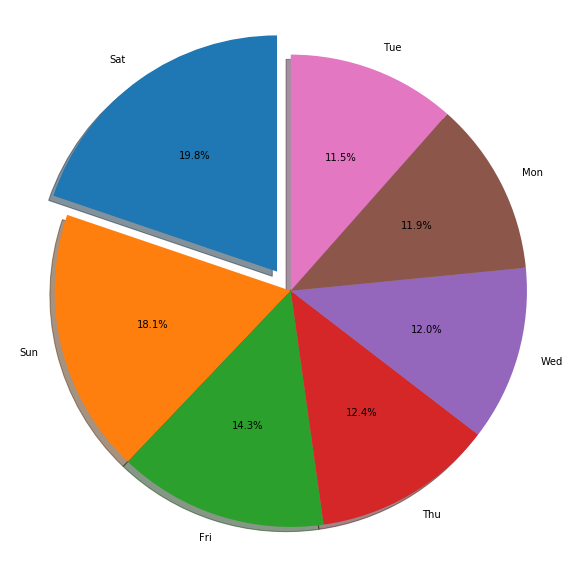

<Figure size 1440x1440 with 0 Axes>

In [88]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(checkin_dow_total.index)
sizes = np.array(checkin_dow_total/sum(checkin_dow_total)).round(4)*100
explode = (0.1, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# which time period has the most checkin counts?

In [92]:
checkin_df.head()

,business_id,day_of_week,checkin_hours,check_in_counts
0,--cZ6Hhc9F7VkKXxHMVZSQ,Fri,0,18.0
1,-06-Fdi30wJx-JA8P7CAng,Fri,0,2.0
2,-0CTrPQNiSyClxhdO4HSDQ,Fri,0,2.0
3,-1xCh7Cocn6IwFzhELyohA,Fri,0,2.0
4,-5L8zOxibac-vBrsYtxXbQ,Fri,0,18.0


In [100]:
checkin_hours_total = checkin_df.groupby("checkin_hours")['check_in_counts'].sum()
checkin_hours_top10 = checkin_df.groupby("checkin_hours")['check_in_counts'].sum().sort_values(ascending = False)[:10]

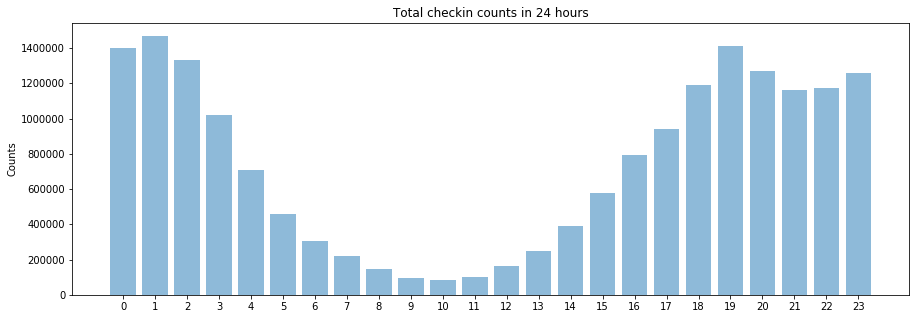

In [115]:
objects = checkin_hours_total.index
y_pos = np.arange(len(objects))
performance = list(checkin_hours_total)

fig2, ax1 = plt.subplots(figsize=(15, 5))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Total checkin counts in 24 hours')

plt.show()

# Build a regression model for checkin counts. 

Response: checkin counts
Predictors: noise level, appointment, outdoorseating, good for kids,

In [117]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [ ]:
reg.fit()

In [119]:
attributes.shape

(162807, 39)

In [121]:
attributes.head()

,BikeParking,BusinessAcceptsCreditCards,BusinessParking,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,...,Music,Smoking,ByAppointmentOnly,AcceptsInsurance,BusinessAcceptsBitcoin,HairSpecializesIn,AgesAllowed,RestaurantsCounterService,Open24Hours,DietaryRestrictions
business_id,,,,,,,,,,,,,,,,,,,,,
--1UhMGODdWsrMastO9DZw,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",True,NaN,quiet,True,casual,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--6MefnULPED_I942VcFNA,False,True,"{'garage': False, 'street': False, 'validated'...",True,False,average,False,casual,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--7zmmkVg-IMGaXbuVd0SQ,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--8LPVSo5i0Oo61X01sV9A,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN
--9QQLMTbFzLJ_oT-ON3Xw,NaN,True,"{'garage': False, 'street': False, 'validated'...",True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
len(attributes.index.unique())

162807

In [129]:
len(np.unique(checkin_df.index))

4171864